# Prjctr HW13. Time series analysis
1. Train a baseline predictions with different statistics and various time windows, validate and make predictions on test set.
2. Train a boosting model, validate and make predictions on test set. (optional)

https://www.kaggle.com/c/competitive-data-science-predict-future-sales/

In [13]:
# !pip install numpy pandas scikit-learn 
# !pip install ydata-profiling ipywidgets setuptools 
# !pip install --upgrade pip


[notice] A new release of pip is available: 24.1.2 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error

In [4]:
train_file = r'C:\Users\De\.kaggle\predict-future-sales\sales_train.csv'
test_file = r'C:\Users\De\.kaggle\predict-future-sales\test.csv'

train_data_raw = pd.read_csv(train_file)
test_data = pd.read_csv(test_file)

In [5]:
print(train_data_raw.info())
train_data_raw

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
 #   Column          Dtype  
---  ------          -----  
 0   date            object 
 1   date_block_num  int64  
 2   shop_id         int64  
 3   item_id         int64  
 4   item_price      float64
 5   item_cnt_day    float64
dtypes: float64(2), int64(3), object(1)
memory usage: 134.4+ MB
None


,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0
...,...,...,...,...,...,...
2935844,10.10.2015,33,25,7409,299.00,1.0
2935845,09.10.2015,33,25,7460,299.00,1.0
2935846,14.10.2015,33,25,7459,349.00,1.0
2935847,22.10.2015,33,25,7440,299.00,1.0


In [6]:
print(test_data.info())
test_data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 214200 entries, 0 to 214199
Data columns (total 3 columns):
 #   Column   Non-Null Count   Dtype
---  ------   --------------   -----
 0   ID       214200 non-null  int64
 1   shop_id  214200 non-null  int64
 2   item_id  214200 non-null  int64
dtypes: int64(3)
memory usage: 4.9 MB
None


,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268
...,...,...,...
214195,214195,45,18454
214196,214196,45,16188
214197,214197,45,15757
214198,214198,45,19648


In [7]:
train_data_raw.isnull().sum(axis=0)

date              0
date_block_num    0
shop_id           0
item_id           0
item_price        0
item_cnt_day      0
dtype: int64

In [8]:
train_data_dates = pd.to_datetime(train_data_raw.date, format='%d.%m.%Y').dt.date
train_data_dates.min(), train_data_dates.max()

(datetime.date(2013, 1, 1), datetime.date(2015, 10, 31))

In [ ]:
from ydata_profiling import ProfileReport
from datetime import datetime

train_data_report = ProfileReport(train_data_raw, explorative=True)
train_data_report


[notice] A new release of pip is available: 24.1.2 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


  Using cached setuptools-75.1.0-py3-none-any.whl.metadata (6.9 kB)
Using cached setuptools-75.1.0-py3-none-any.whl (1.2 MB)


Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

<Axes: >

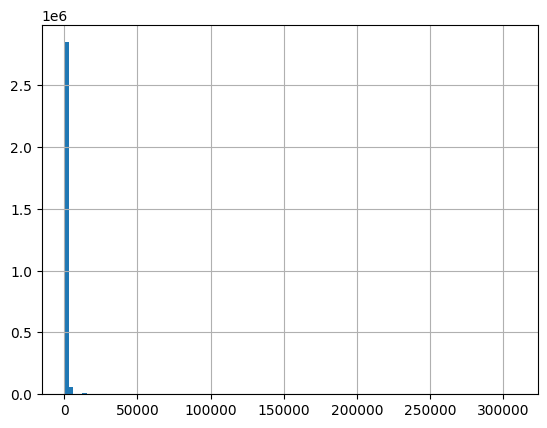

In [ ]:
train_data_raw['item_price'].hist(bins=100)

quantile=0.95
< 69.0:			 n=68312,	 range=-1.0 - 68.9
>= 69.0 & <= 3300.0:	 n=2794334,	 range=69.0 - 3300.0
> 3300.0:		 n=73203,	 range=3308.0 - 307980.0
Verify: 95.2% of data is in the middle range


(69.0, 3300.0)

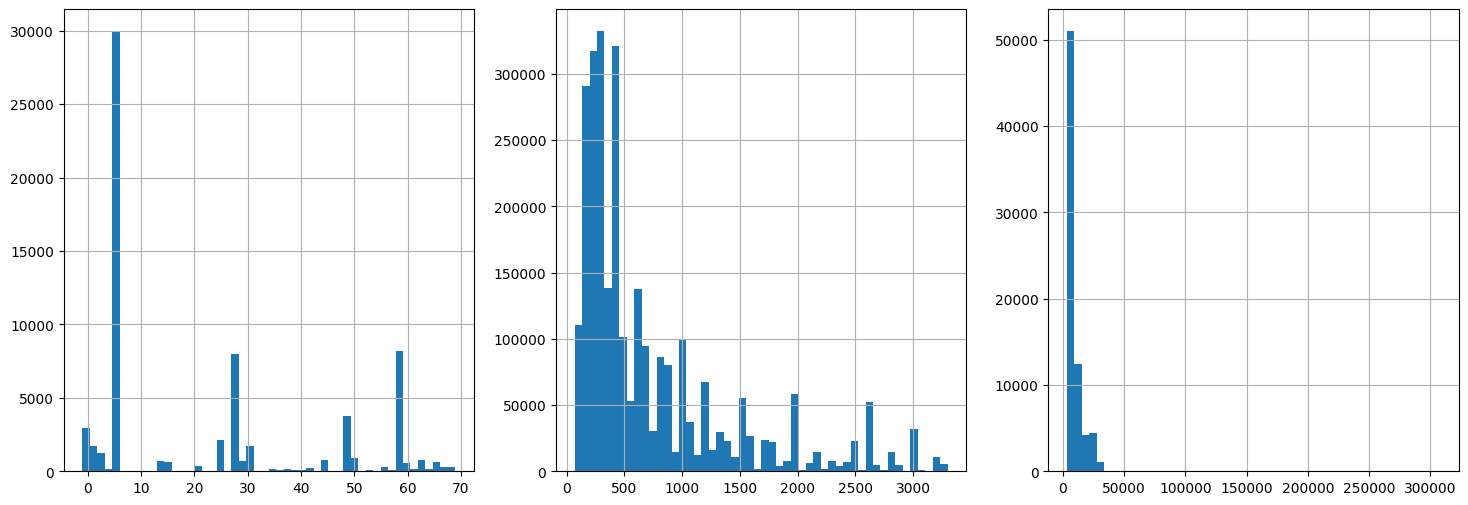

In [ ]:
def show_by_quantile(df, column, quantile=0.98):
    lower_threshold = df[column].quantile((1-quantile)/2.0)
    upper_threshold = df[column].quantile(1-(1-quantile)/2.0)
            
    lower = df[df[column] < lower_threshold]
    middle = df[(df[column] >= lower_threshold) & (df[column] <= upper_threshold)]
    upper = df[df[column] > upper_threshold]
    
    print(f'quantile={quantile}')
    print(f'< {lower_threshold}:\t\t\t n={len(lower)},\t range={lower[column].min()} - {lower[column].max()}')
    print(f'>= {lower_threshold} & <= {upper_threshold}:\t n={len(middle)},\t range={middle[column].min()} - {middle[column].max()}')
    print(f'> {upper_threshold}:\t\t n={len(upper)},\t range={upper[column].min()} - {upper[column].max()}')
    print(f'Verify: {100 * len(middle)/len(df):.1f}% of data is in the middle range')
    
    plt.figure(figsize=(18, 6))
    plt.subplot(1, 3, 1)
    lower[column].hist(bins=50)
    
    
    plt.subplot(1, 3, 2)
    middle[column].hist(bins=50)
    
    
    plt.subplot(1, 3, 3)
    upper[column].hist(bins=50)
    
    return lower_threshold, upper_threshold
    
show_by_quantile(train_data_raw, 'item_price', 0.95)

In [ ]:
date_block_num_boundaries = (train_data_raw.date_block_num.min(), train_data_raw.date_block_num.max())
date_block_num_range = np.array(range(train_data_raw.date_block_num.min(), train_data_raw.date_block_num.max() + 1))
print('date_block_num:', date_block_num_boundaries, date_block_num_range)
print('item_cnt_day:', train_data_raw.item_cnt_day.min(), train_data_raw.item_cnt_day.max())

date_block_num: (0, 33) [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33]
item_cnt_day: -22.0 2169.0


In [ ]:
target_column = 'item_cnt_month'
target_column_pred = target_column +'_pred'

time_block_column = 'date_block_num'
target_index_columns = ["shop_id", "item_id"]
grid_index_columns = [time_block_column] + target_index_columns
print('target_index_columns:', target_index_columns)
print('grid_index_columns:', grid_index_columns)

target_index_columns: ['shop_id', 'item_id']
grid_index_columns: ['date_block_num', 'shop_id', 'item_id']


In [10]:
all_data = train_data_raw.groupby(grid_index_columns)["item_cnt_day"].sum().reset_index(name=target_column)
all_data

NameError: name 'grid_index_columns' is not defined

In [13]:
all_data[target_column].value_counts(normalize=True)*100

item_cnt_month
1.0      65.801330
2.0      16.499785
3.0       6.415105
4.0       3.314039
5.0       1.987044
           ...    
529.0     0.000062
360.0     0.000062
530.0     0.000062
776.0     0.000062
165.0     0.000062
Name: proportion, Length: 446, dtype: float64

In [14]:
all_data[target_column] = all_data[target_column].clip(0,20).astype(int)
all_data[target_column].value_counts(normalize=True)*100

item_cnt_month
1     65.801330
2     16.499785
3      6.415105
4      3.314039
5      1.987044
6      1.288341
7      0.873767
20     0.776323
8      0.648179
9      0.468578
10     0.373682
11     0.278599
12     0.230809
0      0.217385
13     0.189606
14     0.152132
15     0.129014
16     0.108755
17     0.098004
18     0.080603
19     0.068919
Name: proportion, dtype: float64

In [15]:
def create_grid(df):
    date_blocks = np.array(range(df[time_block_column].min(), df[time_block_column].max() + 1))
    shop_ids = df['shop_id'].unique()
    item_ids = df['item_id'].unique()
    
    all_combinations = pd.DataFrame(
        list(itertools.product(date_blocks, shop_ids, item_ids)),
        columns=grid_index_columns
    )
    
    return pd.merge(all_combinations, df, on=grid_index_columns, how='left').fillna(0)


def create_grid_or_load_existing(df, file_path):
    data_grid = None
    if os.path.exists(file_path):
        data_grid = pd.read_pickle(file_path)
    else:
        data_grid = create_grid(df)
        data_grid.to_pickle(file_path)
        
    return data_grid

train_data_grid = create_grid_or_load_existing(
    all_data,
    r'C:\Users\De\.kaggle\predict-future-sales\train_data_by_month.pkl'
)
train_data_grid

,date_block_num,shop_id,item_id,item_cnt_month
0,0,0,32,6.0
1,0,0,33,3.0
2,0,0,35,1.0
3,0,0,43,1.0
4,0,0,51,2.0
...,...,...,...,...
44486275,33,36,12733,0.0
44486276,33,36,13092,0.0
44486277,33,36,16797,0.0
44486278,33,36,18060,0.0


In [16]:
train_data_grid[target_column].value_counts(normalize=True)*100

item_cnt_month
0.0     96.390739
1.0      2.380116
2.0      0.596818
3.0      0.232042
4.0      0.119873
5.0      0.071874
6.0      0.046601
7.0      0.031605
20.0     0.028081
8.0      0.023445
9.0      0.016949
10.0     0.013517
11.0     0.010077
12.0     0.008349
13.0     0.006858
14.0     0.005503
15.0     0.004667
16.0     0.003934
17.0     0.003545
18.0     0.002916
19.0     0.002493
Name: proportion, dtype: float64

In [17]:
train_data_grid.loc[(train_data_grid["shop_id"] == 2) & (train_data_grid["item_id"] == 486)].head(3)

,date_block_num,shop_id,item_id,item_cnt_month
60841,0,2,486,0.0
1369261,1,2,486,0.0
2677681,2,2,486,0.0


In [18]:
def generate_folds(data_index, test_size=1, min_train_size=1, max_train_size=None, max_foldes=None):    
    data_size = len(data_index)
    max_train_size = (data_size - test_size) if max_train_size is None else max_train_size
    max_foldes_ = int((data_size - min_train_size)/test_size)
    n_splits = max_foldes_ if max_foldes is None or max_foldes > max_foldes_ else max_foldes
    
    time_series_split = TimeSeriesSplit(n_splits=n_splits, test_size=test_size, max_train_size=max_train_size).split(data_index)
    return [(data_index[train_index], data_index[test_index]) for train_index, test_index in time_series_split]

# folds = generate_folds(date_block_num_range, 1, 12, 12)
folds = generate_folds(date_block_num_range, 1, 12, 12, 5)
print(len(folds))
folds

5


[(array([17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]), array([29])),
 (array([18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]), array([30])),
 (array([19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]), array([31])),
 (array([20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]), array([32])),
 (array([21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32]), array([33]))]

In [19]:
def get_fold_data(data, fold):
    train_data = data[data[time_block_column].isin(fold[0])]
    val_data = data[data[time_block_column].isin(fold[1])]
    return train_data, val_data

get_fold_data(train_data_grid, folds[0])

(          date_block_num  shop_id  item_id  item_cnt_month
 22243140              17        0       32             0.0
 22243141              17        0       33             0.0
 22243142              17        0       35             0.0
 22243143              17        0       43             0.0
 22243144              17        0       51             0.0
 ...                  ...      ...      ...             ...
 37944175              28       36    12733             0.0
 37944176              28       36    13092             0.0
 37944177              28       36    16797             0.0
 37944178              28       36    18060             0.0
 37944179              28       36    15925             0.0
 
 [15701040 rows x 4 columns],
           date_block_num  shop_id  item_id  item_cnt_month
 37944180              29        0       32             0.0
 37944181              29        0       33             0.0
 37944182              29        0       35             0.0
 3794418

In [20]:
def process_fold(data, fold, predict_delegate, time_block_column):
    val_data = data[data[time_block_column].isin(fold[1])].drop(columns=time_block_column).set_index(target_index_columns)
    pred = predict_delegate(val_data.index, data, fold[0])
    return mean_squared_error(val_data[target_column], pred)


def predict_constant_value(const_value, index):
    return pd.Series([const_value] * len(index), index=index)


def process_folds(model_name, data, folds, predict_delegate):
    errors = [process_fold(
        data,
        fold,
        predict_delegate,
        time_block_column
    ) for fold in folds]
    return f'MSE for {model_name} prediction', errors


const_0_res = process_folds(
    'const 0',
    train_data_grid,
    folds,
    lambda index, data, train_fold: predict_constant_value(0, index)
)
const_0_res

('MSE for const 0 prediction',
 [0.20455664083398298,
  0.18353357484599747,
  0.19874657984439248,
  0.2342535271548891,
  0.24714311918191406])

In [21]:
def predict_window(window_size, agg_func, index, data, train_fold):
    train_time_blocks = train_fold[len(train_fold) - window_size:]
    print(f'train_time_blocks: {train_time_blocks}')
    
    grouped_train_data = data[data[time_block_column].isin(train_time_blocks)].groupby(target_index_columns)
    return grouped_train_data[target_column].agg(agg_func)[index].clip(0,20)


last_1_month_res = process_folds(
    'last month mean',
    train_data_grid,
    folds,
    lambda index, data, train_fold: predict_window(1, 'mean', index, data, train_fold)
)
last_1_month_res

train_time_blocks: [28]
train_time_blocks: [29]
train_time_blocks: [30]
train_time_blocks: [31]
train_time_blocks: [32]


('MSE for last month mean prediction',
 [0.1667805444734871,
  0.1410441601320677,
  0.1567455404228,
  0.19103957444857156,
  0.2537342749270112])

In [22]:
last_3_month_res = process_folds(
    'last 3 months mean',
    train_data_grid,
    folds,
    lambda index, data, train_fold: predict_window(3, 'mean', index, data, train_fold)
)
last_3_month_res

train_time_blocks: [26 27 28]
train_time_blocks: [27 28 29]
train_time_blocks: [28 29 30]
train_time_blocks: [29 30 31]
train_time_blocks: [30 31 32]


('MSE for last 3 months mean prediction',
 [0.14860535777672482,
  0.12385421602645426,
  0.13463940392908155,
  0.18153336764103953,
  0.19959255352936292])

In [23]:
def merge_results(res):
    dfs = []
    for r in res:
        cols = {'model': [r[0]]}
        for i, e in enumerate(r[1]):
            cols[f'fold_{i}'] = [e]
        dfs.append(pd.DataFrame(cols))
        
    df = pd.concat(dfs).reset_index(drop=True)
    df['folds_mean'] = df.iloc[:,1:].mean(axis=1)
    return df

merge_results( [
    const_0_res,
    last_1_month_res,
    last_3_month_res
])

,model,fold_0,fold_1,fold_2,fold_3,fold_4,folds_mean
0,MSE for const 0 prediction,0.204557,0.183534,0.198747,0.234254,0.247143,0.213647
1,MSE for last month mean prediction,0.166781,0.141044,0.156746,0.191040,0.253734,0.181869
2,MSE for last 3 months mean prediction,0.148605,0.123854,0.134639,0.181533,0.199593,0.157645


In [24]:
# repeat the training pipeline from workshop lecture
# make three submissions to the leaderboard to see how well the model is doing and if results are correlated with the local validation

In [26]:
def get_relevant_data(all_data, key_data, key_columns):
    df = all_data.merge(key_data, on=key_columns, how='left')
    df = df.loc[~df['ID'].isna(), all_data.columns]
    return df, df[key_columns].drop_duplicates().set_index(key_columns).index

relevant_training_data, train_test_common_index = get_relevant_data(train_data_grid, test_data, target_index_columns)

const_0_pred = test_data.copy()
const_0_pred[target_column] = 0
const_0_pred[['ID', target_column]].to_csv('const_0_pred.csv', index=False)
const_0_pred

,ID,shop_id,item_id,item_cnt_month
0,0,5,5037,0
1,1,5,5320,0
2,2,5,5233,0
3,3,5,5232,0
4,4,5,5268,0
...,...,...,...,...
214195,214195,45,18454,0
214196,214196,45,16188,0
214197,214197,45,15757,0
214198,214198,45,19648,0


In [27]:
pred = predict_window(1, 'mean', train_test_common_index, relevant_training_data, date_block_num_range).reset_index()
last_1_month_pred = test_data.merge(pred, on=target_index_columns, how='left').fillna(0).rename(columns={0: target_column})
last_1_month_pred[['ID', target_column]].to_csv('last_1_month_pred.csv', index=False)
last_1_month_pred

train_time_blocks: [33]


,ID,shop_id,item_id,item_cnt_month
0,0,5,5037,0.0
1,1,5,5320,0.0
2,2,5,5233,1.0
3,3,5,5232,0.0
4,4,5,5268,0.0
...,...,...,...,...
214195,214195,45,18454,1.0
214196,214196,45,16188,0.0
214197,214197,45,15757,0.0
214198,214198,45,19648,0.0


In [28]:
pred = predict_window(3, 'mean', train_test_common_index, relevant_training_data, date_block_num_range).reset_index()
last_3_month_pred = test_data.merge(pred, on=target_index_columns, how='left').fillna(0).rename(columns={0: target_column})
last_3_month_pred[['ID', target_column]].to_csv('last_3_month_pred.csv', index=False)
last_3_month_pred

train_time_blocks: [31 32 33]


,ID,shop_id,item_id,item_cnt_month
0,0,5,5037,1.333333
1,1,5,5320,0.000000
2,2,5,5233,1.666667
3,3,5,5232,0.333333
4,4,5,5268,0.000000
...,...,...,...,...
214195,214195,45,18454,0.333333
214196,214196,45,16188,0.000000
214197,214197,45,15757,0.000000
214198,214198,45,19648,0.000000


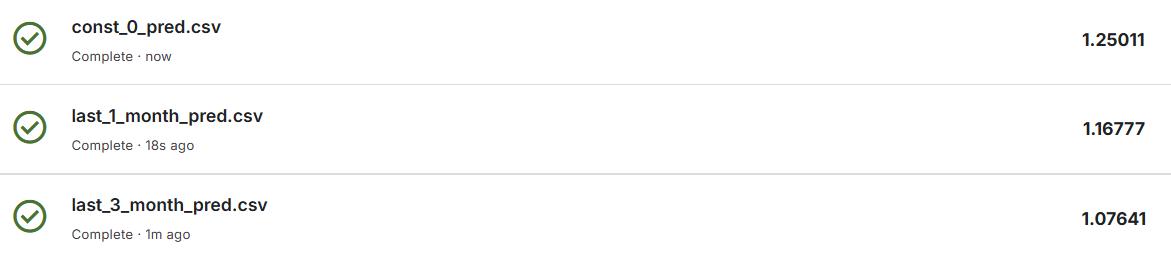

In [59]:
def create_lag_features(data, n):
    for i in range(1, n+1):
        lag_col = f'lag_{i}_{target_column}'
        data[lag_col] = data.groupby(target_index_columns)[target_column].shift(i).fillna(0)

create_lag_features(train_data_grid, 3)
train_data_grid

,date_block_num,shop_id,item_id,item_cnt_month,lag_1_item_cnt_month,lag_2_item_cnt_month,lag_3_item_cnt_month
0,0,0,32,6.0,0.0,0.0,0.0
1,0,0,33,3.0,0.0,0.0,0.0
2,0,0,35,1.0,0.0,0.0,0.0
3,0,0,43,1.0,0.0,0.0,0.0
4,0,0,51,2.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...
44486275,33,36,12733,0.0,0.0,0.0,0.0
44486276,33,36,13092,0.0,0.0,0.0,0.0
44486277,33,36,16797,0.0,0.0,0.0,0.0
44486278,33,36,18060,0.0,0.0,0.0,0.0


In [30]:
folds = generate_folds(date_block_num_range, 1, 3, 3, 5)
folds

[(array([26, 27, 28]), array([29])),
 (array([27, 28, 29]), array([30])),
 (array([28, 29, 30]), array([31])),
 (array([29, 30, 31]), array([32])),
 (array([30, 31, 32]), array([33]))]

In [31]:
import lightgbm as lgb
from copy import deepcopy

lgb_params = {
    #default
    "objective": "regression_l2",
    #"learning_rate": 0.3,
    "metric": "rmse",
    "seed": 42,

    #regularization
    #"max_leaves": 32,
    #"colsample_bytree": 0.8,
    #"subsample": 0.8,
    #"subsample_freq": 1,
    #"min_data_in_leaf": 15
}

In [ ]:
max_rounds = 300

def lgb_train_fold(data, fold, time_block_column, target_column):
    train_data, val_data = get_fold_data(data, fold)
    lgb_train = lgb.Dataset(train_data.drop(columns=[time_block_column, target_column]), label=train_data[target_column], free_raw_data=False)
    lgb_val = lgb.Dataset(val_data.drop(columns=[time_block_column, target_column]), label=val_data[target_column], free_raw_data=False)
    results = {}
    model = lgb.train(
        lgb_params, 
        lgb_train,
        max_rounds,
        valid_sets=(lgb_val, lgb_train),
        valid_names=("val", "train"), 
        callbacks=[
            lgb.log_evaluation(period=1), 
            lgb.record_evaluation(results)
        ]
    )    
    return model, results

lgb_all_folds_results = [lgb_train_fold(train_data_grid, f, time_block_column, target_column) for f in folds]

In [63]:
train_rmse = {f'fold_{i+1}': f[1]["val"]["rmse"] for i, f in enumerate(lgb_all_folds_results)}
train_rmse_df = pd.DataFrame(train_rmse)
train_rmse_df['mean'] = train_rmse_df.mean(axis=1)
n_rounds = train_rmse_df['mean'].argmin(axis=0)
n_rounds, train_rmse_df.iloc[n_rounds]

(40,
 fold_1    0.348537
 fold_2    0.316327
 fold_3    0.344159
 fold_4    0.396482
 fold_5    0.432508
 mean      0.367603
 Name: 40, dtype: float64)

In [32]:
def lgb_train(data, n_rounds, time_block_column, target_column):
    lgb_train = lgb.Dataset(data.drop(columns=[time_block_column, target_column]), label=data[target_column], free_raw_data=False)
    model = lgb.train(lgb_params, lgb_train, n_rounds)
    return model

n_rounds = 40
lgb_model = lgb_train(train_data_grid, n_rounds, time_block_column, target_column)
lgb_model

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.666551 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 376
[LightGBM] [Info] Number of data points in the train set: 44486280, number of used features: 5
[LightGBM] [Info] Start training from score 0.073167


In [60]:
test_data.shape

(214200, 3)

In [56]:
test_time_block = date_block_num_range.max() + 1
test_data_ex = test_data.drop(columns=['ID']).copy()
test_data_ex[time_block_column] = test_time_block
test_data_ex[target_column] = None

test_data_grid = create_grid_or_load_existing(
    pd.concat([relevant_training_data, test_data_ex]),
    r'C:\Users\De\.kaggle\predict-future-sales\train_plus_test_data_by_month.pkl'
)
create_lag_features(test_data_grid, 3)
test_data_grid

C:\Users\De\AppData\Local\Temp\ipykernel_28532\2278759937.py:7: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pd.concat([relevant_training_data, test_data_ex]),


,date_block_num,shop_id,item_id,item_cnt_month,lag_1_item_cnt_month,lag_2_item_cnt_month,lag_3_item_cnt_month
0,0,2,32,0.0,0.0,0.0,0.0
1,0,2,33,1.0,0.0,0.0,0.0
2,0,2,51,0.0,0.0,0.0,0.0
3,0,2,88,0.0,0.0,0.0,0.0
4,0,2,149,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...
7496995,34,36,15033,0.0,0.0,0.0,0.0
7496996,34,36,7572,0.0,0.0,0.0,0.0
7496997,34,36,9030,0.0,0.0,0.0,0.0
7496998,34,36,1867,0.0,0.0,0.0,0.0


In [57]:
test_data_grid = test_data_grid[test_data_grid[time_block_column] == test_time_block].drop(columns=[time_block_column, target_column])
test_data_grid['prediction'] = lgb_model.predict(test_data_grid)
test_data_grid

,shop_id,item_id,lag_1_item_cnt_month,lag_2_item_cnt_month,lag_3_item_cnt_month,prediction
7282800,2,32,0.0,0.0,1.0,0.154849
7282801,2,33,0.0,1.0,0.0,0.201659
7282802,2,51,0.0,0.0,0.0,0.017704
7282803,2,88,0.0,0.0,0.0,0.017704
7282804,2,149,0.0,0.0,0.0,0.017704
...,...,...,...,...,...,...
7496995,36,15033,0.0,0.0,0.0,0.021762
7496996,36,7572,0.0,0.0,0.0,0.022611
7496997,36,9030,0.0,0.0,0.0,0.021762
7496998,36,1867,0.0,0.0,0.0,0.024534


In [58]:
test_data_with_prediction = test_data.merge(test_data_grid, on=target_index_columns, how='inner')[['ID', 'prediction']].rename(columns={'prediction': target_column}).set_index('ID')
test_data_with_prediction.to_csv('homework 08. lgb_pred.csv')

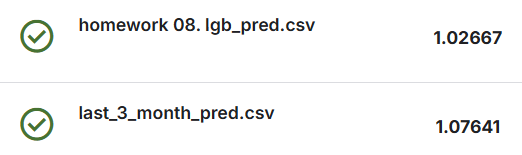